In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
# from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob

In [3]:
torch.backends.cudnn.benchmark=True

## Data

In [4]:
PATH = Path('../data/all')

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [6]:
VEHICLES=10
ROADS=7
ROAD_LINES=6

In [38]:
S_PREFIX = '24-unet'

In [8]:
from torchvision.datasets.folder import pil_loader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TTF

### Create dataloader

In [9]:
class MatchedFilesDataset(Dataset):
    def __init__(self, fnames, y, tfms, path):
        self.path,self.fnames = path,fnames
        self.open_fn = pil_loader
        self.y=y
        self.open_y_fn = pil_loader
        assert(len(fnames)==len(y))
        
        self.n = self.get_n()
        self.c = self.get_c()
        self.tfms = tfms
#         self.sz = self.get_sz()
        
#     def get_sz(self): return self.transform.sz
    def get_x(self, i): return self.open_fn(os.path.join(self.path, self.fnames[i]))
    def get_y(self, i): return self.open_y_fn(os.path.join(self.path, self.y[i]))
    def get_n(self): return len(self.fnames)
    def get_c(self): return 2
    
    def get(self, tfms, x, y):
        for fn in tfms:
            #pdb.set_trace()
            x, y = fn(x, y)
        return (x, y)
    
    def __getitem__(self, idx):
        x,y = self.get_x(idx),self.get_y(idx)
        return self.get(self.tfms, x, y)
    
    def __len__(self): return self.n

    def resize_imgs(self, targ, new_path):
        dest = resize_imgs(self.fnames, targ, self.path, new_path)
        return self.__class__(self.fnames, self.y, self.transform, dest)

In [10]:

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)
    
    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [11]:
def crop_bg_pil(x,y):
    w, h = x.size
    top = int(h/3.75)
    bot = int(h*.9 + h/150)
    pad_right=16-w%16
    return TTF.crop(x, top, 0, bot-top, w+pad_right), TTF.crop(y, top, 0, bot-top, w+pad_right)

In [12]:
class RHF(object):
    def __init__(self, p=0.5): self.p = p
    def __call__(self, x, y):
        if random.random() < self.p:
            return TTF.hflip(x), TTF.hflip(y)
        return x,y

In [13]:
class RR(object):
    def __init__(self, degrees=2): self.degrees = degrees
    def __call__(self, x, y):
        angle = random.uniform(-self.degrees, self.degrees)
        return TTF.rotate(x, angle), TTF.rotate(y, angle)

In [14]:
def tfm_x_wrapper(tfm):
    return lambda x,y: (tfm(x), y)

In [15]:
class RRC(transforms.RandomResizedCrop):
    def __call__(self, x, y):
        i, j, h, w = self.get_params(x, self.scale, self.ratio)
        x = TTF.resized_crop(x, i, j, h, w, self.size, self.interpolation)
        y = TTF.resized_crop(y, i, j, h, w, self.size, self.interpolation)
        return x, y

In [16]:
class RC():
    def __init__(self, targ_sz):
        self.targ_sz = targ_sz

    def __call__(self, x, y):
        rand_w = random.uniform(0, 1)
        rand_h = random.uniform(0, 1)
        w,h = x.size
        t_w,t_h = self.targ_sz
        start_x = np.floor(rand_w*(w-t_w)).astype(int)
        start_y = np.floor(rand_h*(h-t_h)).astype(int)
        return TTF.crop(x, start_y, start_x, t_h, t_w), TTF.crop(y, start_y, start_x, t_h, t_w)

In [17]:
def convert_y(y_img):
    y_new = np.zeros(y_img.shape, dtype=int)
    y_new[y_img==VEHICLES] = 1
    cutoff_y = int(y_new.shape[0]*.83)
    y_new[cutoff_y:,:] = 0

    y_new[y_img==ROADS] = 2
    y_new[y_img==ROAD_LINES] = 2
    return torch.from_numpy(y_new).long()

def xy_tensor(x,y):
    y_img = np.array(y, np.int32, copy=False)
    return TTF.to_tensor(x), convert_y(y_img[:,:,0])

In [18]:
x_names = np.sort(np.array(glob(str(PATH/f'CameraRGB'/'*.png'))))

In [19]:
def torch_loader(f_ext, data_path, bs, size, workers=7, random_crop=False):
    # Data loading code
    x_names = np.sort(np.array(glob(str(data_path/f'CameraRGB{f_ext}'/'*.png'))))
    y_names = np.sort(np.array(glob(str(data_path/f'CameraSeg{f_ext}'/'*.png'))))
    
    x_n = x_names.shape[0]
    val_idxs = list(range(x_n-300, x_n))
#     val_idxs = list(range(300))
    ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
    normalize = transforms.Normalize(mean=[0.4914 , 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159])
    
    train_tfms = [
        crop_bg_pil,
        tfm_x_wrapper(transforms.ColorJitter(.2,.2,.2)),
#         tfm_x_wrapper(Lighting(0.1, __imagenet_pca['eigval'], __imagenet_pca['eigvec'])),
        RR(),
        RHF(),
        xy_tensor,
        tfm_x_wrapper(normalize),
    ]
    if random_crop:
        train_tfms.insert(3,RRC(size, scale=(0.4, 1.0)))
    train_dataset = MatchedFilesDataset(trn_x, trn_y, train_tfms, path='')
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_tfms = [
        crop_bg_pil,
        xy_tensor,
        tfm_x_wrapper(normalize)
    ]
    val_dataset = MatchedFilesDataset(val_x, val_y, val_tfms, path='')
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs, shuffle=False,
        num_workers=workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    return data


In [20]:
def denorm(x):
    x_np = x.cpu().numpy()
    x_np = np.rollaxis(x_np, 0, 3)
    mean=np.array([0.4914 , 0.48216, 0.44653])
    std=np.array([0.24703, 0.24349, 0.26159])
    x_np = x_np*std+mean
    return x_np

In [21]:
def new_acc(preds, targs):
    mx,idx = torch.max(preds, 1)
    return (idx == targs).float().mean()
def dice_mult(pred, targs):
#     pred = (pred>0).float()
    mx,idx = torch.max(pred, 1)
    pred = idx.float()
    targs = targs.float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

## U-net

In [22]:
BN_EPS = 1e-4  #1e-4  #1e-5
class ConvBnRelu2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, dilation=1, stride=1, groups=1, is_bn=True, is_relu=True):
        super(ConvBnRelu2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride, dilation=dilation, groups=groups, bias=False)
        self.bn   = nn.BatchNorm2d(out_channels, eps=BN_EPS)
        self.relu = nn.ReLU(inplace=True)
        if is_bn   is False: self.bn  =None
        if is_relu is False: self.relu=None


    def forward(self,x):
        x = self.conv(x)
        if self.bn   is not None: x = self.bn(x)
        if self.relu is not None: x = self.relu(x)
        return x

In [23]:
class ConvResidual (nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ConvResidual, self).__init__()

        self.block = nn.Sequential(
            ConvBnRelu2d(in_channels,  out_channels, kernel_size=3, padding=1,  stride=1 ),
            ConvBnRelu2d(out_channels, out_channels, kernel_size=3, padding=1,  stride=1, is_relu=False),
        )
        self.shortcut = None
        if in_channels!=out_channels or stride!=1:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, stride=stride,  bias=True)

    def forward(self, x):
        r = x if self.shortcut is None else self.shortcut(x)
        x = self.block(x)
        x = F.relu(x.add_(r), inplace=True)
        return x


In [24]:

## origainl 3x3 stack filters used in UNet
class StackEncoder (nn.Module):
    def __init__(self, x_channels, y_channels, kernel_size=3, max_pool=True):
        super(StackEncoder, self).__init__()
        padding=(kernel_size-1)//2
        self.encode = nn.Sequential(
            ConvBnRelu2d(x_channels, y_channels, kernel_size=kernel_size, padding=padding, dilation=1, stride=1, groups=1),
            ConvBnRelu2d(y_channels, y_channels, kernel_size=kernel_size, padding=padding, dilation=1, stride=1, groups=1),
        )
        self.mp = nn.MaxPool2d(2) if max_pool else nn.Conv2d(y_channels, y_channels, kernel_size=kernel_size, padding=padding, stride=2)

    def forward(self,x):
        y = self.encode(x)
        y_small = self.mp(y)
        return y, y_small


class StackDecoder (nn.Module):
    def __init__(self, x_big_channels, x_channels, y_channels, kernel_size=3):
        super(StackDecoder, self).__init__()
        padding=(kernel_size-1)//2

        self.decode = nn.Sequential(
            ConvBnRelu2d(x_big_channels+x_channels, y_channels, kernel_size=kernel_size, padding=padding, dilation=1, stride=1, groups=1),
            ConvBnRelu2d(y_channels, y_channels, kernel_size=kernel_size, padding=padding, dilation=1, stride=1, groups=1),
            ConvBnRelu2d(y_channels, y_channels, kernel_size=kernel_size, padding=padding, dilation=1, stride=1, groups=1),
        )

    def forward(self, x_big, x):
        N,C,H,W = x_big.size()
        y = F.upsample(x, size=(H,W),mode='bilinear')
        #y = F.upsample(x, scale_factor=2,mode='bilinear')
        y = torch.cat([y,x_big],1)
        y = self.decode(y)
        return  y
##---------------------------------------------------------------


## origainl 3x3 stack filters used in UNet
class ResStackEncoder (nn.Module):
    def __init__(self, x_channels, y_channels):
        super(ResStackEncoder, self).__init__()
        self.encode = ConvResidual(x_channels, y_channels)

    def forward(self,x):
        y = self.encode(x)
        y_small = F.max_pool2d(y, kernel_size=2, stride=2)
        return y, y_small


class ResStackDecoder (nn.Module):
    def __init__(self, x_big_channels, x_channels, y_channels, kernel_size=3):
        super(ResStackDecoder, self).__init__()
        padding=(kernel_size-1)//2

        self.decode = nn.Sequential(
            ConvBnRelu2d(x_big_channels+x_channels, y_channels, kernel_size=kernel_size, padding=padding, dilation=1, stride=1, groups=1),
            ConvResidual(y_channels, y_channels)
        )

    def forward(self, x_big, x):
        N,C,H,W = x_big.size()
        y = F.upsample(x, size=(H,W),mode='bilinear')
        #y = F.upsample(x, scale_factor=2,mode='bilinear')
        y = torch.cat([y,x_big],1)
        y = self.decode(y)
        return  y


In [25]:
# 256x256
class Unet256 (nn.Module):
    def __init__(self, out_c=3, in_c=3, f=2):
        super().__init__()
#         C,H,W = in_shape
        #assert(C==3)

        #256
        self.down2 = StackEncoder(in_c,   64//f, kernel_size=3)   #128
        self.down3 = StackEncoder( 64//f,  128//f, kernel_size=3)   # 64
        self.down4 = StackEncoder(128//f,  256//f, kernel_size=3)   # 32
        self.down5 = StackEncoder(256//f,  512//f, kernel_size=3)   # 16
        self.down6 = StackEncoder(512//f, 1024//f, kernel_size=3)   #  8

        self.center = nn.Sequential(
            #ConvBnRelu2d( 512, 1024, kernel_size=3, padding=1, stride=1 ),
            ConvBnRelu2d(1024//f, 1024//f, kernel_size=3, padding=1, stride=1 ),
        )

        # 8
        # x_big_channels, x_channels, y_channels
        self.up6 = StackDecoder(1024//f,1024//f, 512//f, kernel_size=3)  # 16
        self.up5 = StackDecoder( 512//f, 512//f, 256//f, kernel_size=3)  # 32
        self.up4 = StackDecoder( 256//f, 256//f, 128//f, kernel_size=3)  # 64
        self.up3 = StackDecoder( 128//f, 128//f,  64//f, kernel_size=3)  #128
        self.up2 = StackDecoder(  64//f,  64//f,  32, kernel_size=3)  #256
        self.classify = nn.Conv2d(32, out_c, kernel_size=1, padding=0, stride=1, bias=True)


    def forward(self, x):

        out = x                       #;print('x    ',x.size())
                                      #
        down2,out = self.down2(out)   #;print('down2',down2.size())  #128
        down3,out = self.down3(out)   #;print('down3',down3.size())  #64
        down4,out = self.down4(out)   #;print('down4',down4.size())  #32
        down5,out = self.down5(out)   #;print('down5',down5.size())  #16
        down6,out = self.down6(out)   #;print('down6',down6.size())  #8
        pass                          #;print('out  ',out.size())

        out = self.center(out)
        out = self.up6(down6, out)
        out = self.up5(down5, out)
        out = self.up4(down4, out)
        out = self.up3(down3, out)
        out = self.up2(down2, out)

        out = self.classify(out)
        out = torch.squeeze(out, dim=1)
        return out

In [26]:

# 128x128
class Unet128 (nn.Module):
    def __init__(self, in_c=3, out_c=3, f=1):
        super().__init__()
        #assert(C==3)

        #128
        self.down3 = StackEncoder(in_c,   128//f, kernel_size=3)   # 64
        self.down4 = StackEncoder(128//f,  256//f, kernel_size=3)   # 32
        self.down5 = StackEncoder(256//f,  512//f, kernel_size=3)   # 16
        self.down6 = StackEncoder(512//f, 1024//f, kernel_size=3)   #  8

        self.center = nn.Sequential(
            ConvBnRelu2d(1024//f, 1024//f, kernel_size=3, padding=1, stride=1 ),
        )

        # 8
        # x_big_channels, x_channels, y_channels
        self.up6 = StackDecoder(1024//f,1024//f, 512//f, kernel_size=3)  # 16
        self.up5 = StackDecoder( 512//f, 512//f, 256//f, kernel_size=3)  # 32
        self.up4 = StackDecoder( 256//f, 256//f, 128//f, kernel_size=3)  # 64
        self.up3 = StackDecoder( 128//f, 128//f,  64//f, kernel_size=3)  #128
        self.classify = nn.Conv2d(64//f, out_c, kernel_size=1, padding=0, stride=1, bias=True)


    def forward(self, x):

        out = x                       #;print('x    ',x.size())
        down3,out = self.down3(out)   #;print('down3',down3.size())  #64
        down4,out = self.down4(out)   #;print('down4',down4.size())  #32
        down5,out = self.down5(out)   #;print('down5',down5.size())  #16
        down6,out = self.down6(out)   #;print('down6',down6.size())  #8
        pass                          #;print('out  ',out.size())

        out = self.center(out)
        out = self.up6(down6, out)
        out = self.up5(down5, out)
        out = self.up4(down4, out)
        out = self.up3(down3, out)
        out = self.classify(out)
        out = torch.squeeze(out, dim=1)
        return out

In [27]:
m = Unet256().cuda()

In [ ]:
ext = '-150'
sz = 96
bs = 96
md = torch_loader('-150', PATH, bs, sz, random_crop=True)

In [ ]:
x,y = next(iter(md.trn_dl))

In [ ]:
out = m(VV(x))

## U-net (ish)

In [28]:
def get_base(f):
    cut,lr_cut = model_meta[f]
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers), lr_cut

In [29]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [30]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        if isinstance(self.model, FP16):
            model = self.model.module
        else:
            model = self.model
        if isinstance(model, Unet128):
            return children(model)
        lgs = list(split_by_idxs(children(model.rn), [model.lr_cut]))
#         print('LGS:', lgs)
#         print('Add:', children(model)[1:])
        return lgs + [children(model)[1:]]

In [31]:
def get_learner(md, m_fn=Unet256):
    m = m_fn(f=2)
#     models = UnetModel(m)
    learn = Learner.from_model_data(m, md)
    learn.opt_fn=optim.Adam
    class_weights = torch.FloatTensor([1,10,2]).cuda()
    learn.crit=nn.CrossEntropyLoss(weight=class_weights)
#     learn.crit=nn.CrossEntropyLoss()
#     learn.crit=FocalLoss(2)
#     learn.crit = nn.BCEWithLogitsLoss()
    learn.unfreeze()
    learn.metrics=[new_acc]
    return learn

In [32]:
# learn.half()

### Loading from train6 model

In [48]:
ext = '-150'
sz = 96
bs = 96
md = torch_loader('-150', PATH, bs, sz, random_crop=True)

In [49]:
learn = get_learner(md)

 99%|█████████▊| 72/73 [00:16<00:00,  4.44it/s, loss=4.79] 

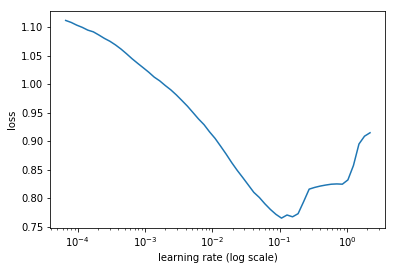

In [35]:
learn.lr_find()
learn.sched.plot()

In [50]:
lr=5e-2
# lr=4e-3
wd=1e-5

In [51]:
learn.fit(lr,1,wds=wd,cycle_len=40,use_clr_beta=(20,20,.95,.85))

epoch      trn_loss   val_loss   new_acc                   
    0      0.399626   0.350591   0.898159  
    1      0.256618   0.152401   0.943315                  
    2      0.214363   0.17226    0.927475                  
    3      0.196384   0.190016   0.983792                  
    4      0.172767   0.08993    0.973857                  
    5      0.165569   0.118258   0.951358                  
    6      0.163911   0.190431   0.90958                   
    7      0.149922   0.071433   0.986915                  
    8      0.153978   0.12647    0.963432                  
    9      0.153028   0.090956   0.98598                   
    10     0.148326   0.131801   0.957109                  
    11     0.140595   0.079675   0.98302                   
    12     0.154358   0.146823   0.971973                  
    13     0.152149   0.116894   0.965176                  
    14     0.154038   0.139412   0.967186                  
    15     0.16757    0.133209   0.967667               

[array([0.0251]), 0.99341228723526]

In [52]:
learn.save(f'128urn-{S_PREFIX}-tmp')

In [62]:
learn.load(f'128urn-{S_PREFIX}-tmp')

In [ ]:
learn.fit(lr/100,1,wds=wd,cycle_len=10,use_clr_beta=(20,20,.95,.85))

In [63]:
learn.save(f'128urn-{S_PREFIX}-0')

In [ ]:
learn.load(f'128urn-{S_PREFIX}-0')

In [ ]:
ext = '-150'
sz = 96
bs = 96
md = torch_loader('-150', PATH, bs, sz, random_crop=True)

In [ ]:
learn.fit(lr,1,wds=wd,cycle_len=40,use_clr_beta=(20,20,.95,.85))

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
py = np.argmax(py,1)

In [ ]:
show_img(denorm(x[0]))

In [ ]:
show_img(py[0]);

In [ ]:
show_img(y[0]);

## 256x256

In [64]:
ext = '-300'
sz=192
bs=32
# md = torch_loader(ext, PATH, bs, sz)
md = torch_loader(ext, PATH, bs, sz, random_crop=True)

In [65]:
lr=1e-2
wd=1e-6

In [66]:
import gc
gc.collect()

3803

In [67]:
learn = get_learner(md)

In [ ]:
learn.load(f'128urn-{S_PREFIX}-0')

 89%|████████▉ | 195/219 [00:30<00:03,  6.32it/s, loss=0.551]

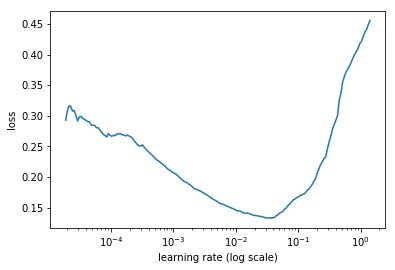

In [71]:
learn.lr_find()
learn.sched.plot()

In [72]:
learn.load(f'128urn-{S_PREFIX}-0')

In [73]:
learn.fit(lr,1,wds=wd,cycle_len=30,use_clr_beta=(20,20,.95,.85))

epoch      trn_loss   val_loss   new_acc                      
    0      0.092412   0.046177   0.989929  
    1      0.076656   0.034282   0.992754                     
    2      0.079165   0.041006   0.993274                     
    3      0.079254   0.035678   0.99078                      
    4      0.077307   0.02768    0.993168                     
    5      0.076721   0.030072   0.991323                     
    6      0.079646   0.036374   0.989055                     
    7      0.070799   0.026043   0.992116                     
    8      0.082247   0.025585   0.993367                     
    9      0.075425   0.033019   0.991408                     
    10     0.087648   0.037124   0.991983                     
    11     0.084219   0.064931   0.986244                     
    12     0.079707   0.033384   0.992282                     
    13     0.076995   0.028723   0.992755                     
    14     0.069124   0.022891   0.992887                     
    15     

[array([0.01411]), 0.9964839545885722]

In [74]:
learn.save(f'256urn-{S_PREFIX}-tmp')

In [75]:
ext = '-300'
sz=192
bs=32
# md = torch_loader(ext, PATH, bs, sz)
md = torch_loader(ext, PATH, bs, sz, random_crop=False)

In [76]:
learn = get_learner(md)

In [77]:
learn.load(f'256urn-{S_PREFIX}-tmp')

In [78]:
learn.fit(lr/100,1,wds=wd,cycle_len=10,use_clr_beta=(20,20,.95,.85))

epoch      trn_loss   val_loss   new_acc                      
    0      0.033853   0.016828   0.995467  
    1      0.025522   0.01388    0.996212                     
    2      0.021564   0.012798   0.996389                     
    3      0.019718   0.012161   0.996528                     
    4      0.019258   0.011904   0.996553                     
    5      0.019194   0.011798   0.996381                     
    6      0.018771   0.011512   0.996649                     
    7      0.01866    0.011636   0.996517                     
    8      0.018728   0.011444   0.996717                     
    9      0.018999   0.011484   0.996655                     


[array([0.01148]), 0.9966547632217407]

In [79]:
learn.save(f'256urn-{S_PREFIX}')

In [ ]:
learn.load(f'256urn-{S_PREFIX}')

In [ ]:
x,y = next(iter(md.trn_dl))

In [ ]:
x.shape

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
py = np.argmax(py,1)

In [ ]:
plt.imshow(denorm(x[-1]))

In [ ]:
show_img(py[-1]);

In [ ]:
py[-1].shape

In [ ]:
y[-1].shape

In [ ]:
show_img(y[-1]);

## 512x512

In [80]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'

In [81]:
ext = ''
sz=288
bs=16
md = torch_loader(ext, PATH, bs, sz, random_crop=True)

In [82]:
learn = get_learner(md)

In [83]:
learn.load(f'256urn-{S_PREFIX}')

 68%|██████▊   | 299/437 [00:51<00:23,  5.80it/s, loss=0.308] 

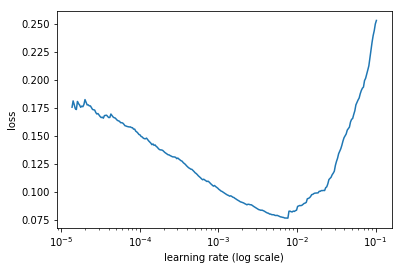

In [84]:
learn.lr_find()
learn.sched.plot()

In [85]:
learn.load(f'256urn-{S_PREFIX}')

In [86]:
lr=1e-3
wd=5e-7

In [87]:
learn.fit(lr,1,wds=wd,cycle_len=8,use_clr_beta=(20,20,.95,.85))

epoch      trn_loss   val_loss   new_acc                      
    0      0.066139   0.077391   0.976612  
    1      0.064424   0.053423   0.986125                     
    2      0.060089   0.044414   0.989192                     
    3      0.058276   0.045079   0.988404                     
    4      0.058156   0.046153   0.988391                     
    5      0.056904   0.044049   0.989496                     
    6      0.056776   0.043291   0.989227                     
    7      0.055841   0.043815   0.989856                     


[array([0.04382]), 0.9898557806015015]

In [88]:
learn.save(f'600urn-{S_PREFIX}-tmp')

In [ ]:
learn.load(f'600urn-{S_PREFIX}-tmp')

In [ ]:
learn.fit(lr/10,1,wds=wd,cycle_len=8,use_clr_beta=(20,10,.95,.85))

In [ ]:
learn.fit(lr/100,1,wds=wd,cycle_len=8,use_clr_beta=(20,20,.95,.85))

In [ ]:
learn.sched.plot_loss()

In [ ]:
learn.save(f'600urn-{S_PREFIX}')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
py = np.argmax(py,1)

In [ ]:
plt.imshow(denorm(x[10]))

In [ ]:
show_img(py[10]);

In [ ]:
py[-1].shape

In [ ]:
y[-1].shape

In [ ]:
show_img(y[10]);

## Save results

In [ ]:
import sys, skvideo.io, json, base64
import numpy as np
from PIL import Image
from io import BytesIO, StringIO

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))

In [ ]:
# model_summary(m, [3,608,800])

In [ ]:
# learn.load('1024urn')
load_model(m, str(PATH/f'models/600urn-{S_PREFIX}.h5'))

In [ ]:
# file = sys.argv[-1]
file = 'test_video.mp4'

if file == 'demo.py':
    print("Error loading video")
    quit

# Define encoder function
def encode(array):
    pil_img = Image.fromarray(array)
    buff = BytesIO()
    pil_img.save(buff, format="PNG")
    return base64.b64encode(buff.getvalue()).decode("utf-8")

video = skvideo.io.vread(file)

In [ ]:
# resized_video = np.array([scipy.misc.imresize(f, size=(512,512)) for f in video])

In [ ]:
def normalize(x):
    if np.mean(x) > 1:
        x = x/255
    m,s = imagenet_stats
    x = (x-m)/s
    return x
def preprocess(video):
    f1_norm = normalize(video)
    f1_roll = np.rollaxis(f1_norm, 3, 1)
    f1_pad = np.pad(f1_roll, [(0,0),(0,0),(0,8),(0,0)], mode='constant')
    return f1_pad

In [ ]:
f1 = preprocess(video)

In [ ]:
results = []
for i in range(0,f1.shape[0],8):
    xv = VV(torch.from_numpy(f1[i:i+8]).contiguous().float())
    preds = m(xv)
    mx,idx = torch.max(preds, 1)
    idx_slice = idx[:,:-8,:]
    results.append(idx_slice)

In [ ]:
r_stacked = torch.cat(results,0)
r_np = r_stacked.data.cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(video[index])
    ax2.imshow(r_np[index])

In [ ]:
plot_res(10)

In [ ]:
answer_key = {}

# Frame numbering starts at 1
frame_idx = 1
for frame in r_np:
    # Look for red cars :)
    binary_car_result = (frame==1).astype('uint8')
#     print(np.mean(binary_car_result))
    
    # Look for road :)
    binary_road_result = (frame==2).astype('uint8')

    answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]
    
    # Increment frame
    frame_idx+=1

# Print output in proper json format
tester_data = json.dumps(answer_key)
with open('tester_data_multi_take2', 'w') as f:
    f.write(tester_data)
print(json.dumps(answer_key))

### Decoding car

In [ ]:
PATH

In [ ]:
from scipy import misc
def decode(packet):
	img = base64.b64decode(packet)
	filename = PATH/'image.png'
	with open(filename, 'wb') as f:
			f.write(img)
	result = misc.imread(filename)
	return result

with open('results.json') as json_data:
	ans_data = json.loads(json_data.read())
	json_data.close()

In [ ]:
def plot_ans(index):
    ans = decode(ans_data[str(index)][0])
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(r_np[index])
    ax1.set_title('Mine', fontsize=35)
    ax2.imshow(ans)
    ax2.set_title('Answer', fontsize=35)
    ax3.imshow(video[index])
    ax2.set_title('Original', fontsize=35)

In [ ]:
plot_ans(10)

In [ ]:
ans = decode(ans_data['1'][0])

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()